# 1D Helmholtz Multilevel Development: Repetitive + Alignment
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [39]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Level 0->1 Coarsening

In [117]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)

### Relaxation

INFO     kh 0.5
INFO     Relax at level 0 size 96
INFO     Iter     |r|                         |x|         RER
INFO     0     1.362e+00                    4.469e-01    3.053
INFO     1     7.424e-01 (0.545) [0.545]    3.380e-01    2.203 (0.721)
INFO     2     4.322e-01 (0.582) [0.563]    2.886e-01    1.504 (0.682)
INFO     3     2.664e-01 (0.617) [0.581]    2.640e-01    1.013 (0.674)
INFO     4     1.786e-01 (0.670) [0.602]    2.504e-01    0.715 (0.706)
INFO     5     1.321e-01 (0.739) [0.627]    2.416e-01    0.548 (0.766)
INFO     6     1.049e-01 (0.793) [0.653]    2.353e-01    0.446 (0.815)
INFO     7     8.827e-02 (0.841) [0.677]    2.305e-01    0.383 (0.859)
INFO     8     7.697e-02 (0.872) [0.698]    2.265e-01    0.340 (0.887)
INFO     9     6.905e-02 (0.897) [0.718]    2.231e-01    0.309 (0.911)
INFO     10    6.305e-02 (0.913) [0.736]    2.201e-01    0.286 (0.925)
INFO     11    5.835e-02 (0.925) [0.751]    2.175e-01    0.268 (0.936)
INFO     12    5.460e-02 (0.936) [0.765]    

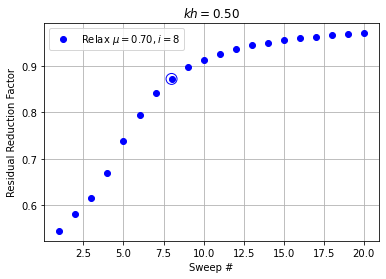

In [118]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []
work = 1

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a.shape[0], ), 
    print_frequency=1, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

title = "Relax"
color = "blue"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

In [119]:
# Generate relaxed vectors.
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating {} TVs with {} sweeps".format(x.shape[1], num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 3 TVs with 8 sweeps
INFO     RER 0.330


### Coarsening

In [120]:
# Coarsening.
aggregate_size = 4
num_components = 2

In [121]:
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

In [122]:
def create_coarsening(x, aggregate_size, num_components):
    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    return hrc.Coarsener(r)

def plot_coarsening(R, x):
    xc = R.dot(x)
    display(pd.DataFrame(R[:5,:10].todense()))

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    ax = axs[0]
    for i in range(2):
        ax.plot(x[:, i])
    ax.set_title("$x$")
    ax.grid(True);

    ax = axs[1]
    for i in range(2):
        ax.plot(xc[::2, i])
    ax.set_title("$x^c$ Species 0")
    ax.grid(True);


    ax = axs[2]
    for i in range(2):
        ax.plot(xc[1::2, i])
    ax.set_title("$x^c$ Species 1")
    ax.grid(True);

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, domain_size, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, domain_size)
    # Use default Kacmzarz for kh != 0.
    local_level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(domain_size // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(local_level, r_csr, nu) for nu in nu_values])

,0,1,2,3,4,5,6,7,8,9
0,-0.46,-0.53,-0.55,-0.46,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.27,0.27,0.65,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.46,-0.53,-0.55,-0.46,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.27,0.27,0.65,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.46,-0.53


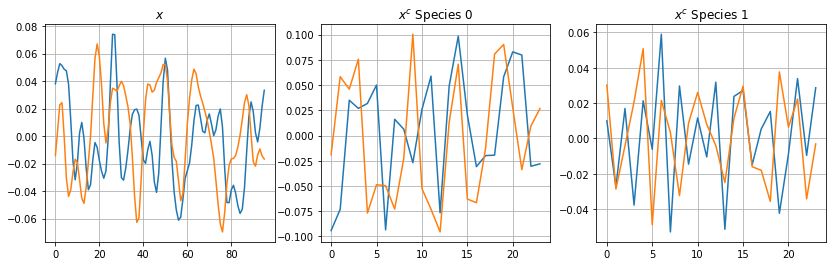

In [123]:
r = create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
On a domain of size $4 a$, $a$ = aggregate size.

In [124]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv factor {}".format(
    np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv factor [0.461 0.235 0.121 0.132 0.103 0.076 0.075 0.071]


### Interpolation
Using $P = R^T$ to start.

In [125]:
# caliber = 2
# interpolation_method = "svd"
# neighborhood = "extended"

# p = create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error,
#     caliber=caliber)

# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

In [126]:
def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = r.tile(m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

In [127]:
# P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

[[-0.456 -0.658]
 [-0.535 -0.271]
 [-0.545  0.272]
 [-0.457  0.648]]


### Local Two-level Cycle (L2C) Rate

In [136]:
nu = 2
local_multilevel = create_two_level_hiearchy(kh, m * aggregate_size, r, p)
y, _ = two_level_conv_factor(local_multilevel, nu, print_frequency=1)

INFO         0 |r| 3.614e+00 RER 1.40331
INFO         1 |r| 1.209e+00 (0.33465) RER 0.10684 (0.07613) 11.320
INFO         2 |r| 3.422e-01 (0.28293) RER 0.03098 (0.29000) 11.044
INFO         3 |r| 1.133e-01 (0.33101) RER 0.01026 (0.33128) 11.035
INFO         4 |r| 3.535e-02 (0.31214) RER 0.00320 (0.31214) 11.035
INFO         5 |r| 1.257e-02 (0.35545) RER 0.00114 (0.35544) 11.036
INFO         6 |r| 4.919e-03 (0.39145) RER 0.00045 (0.39141) 11.037
INFO         7 |r| 1.952e-03 (0.39682) RER 0.00018 (0.39682) 11.037
INFO         8 |r| 7.257e-04 (0.37176) RER 0.00007 (0.37176) 11.037
INFO         9 |r| 2.611e-04 (0.35982) RER 0.00002 (0.35982) 11.037
INFO        10 |r| 9.506e-05 (0.36406) RER 0.00001 (0.36406) 11.037
INFO        11 |r| 3.531e-05 (0.37139) RER 0.00000 (0.37139) 11.037
INFO        12 |r| 1.321e-05 (0.37421) RER 0.00000 (0.37421) 11.037
INFO        13 |r| 4.854e-06 (0.36740) RER 0.00000 (0.36740) 11.037
INFO        14 |r| 1.755e-06 (0.36147) RER 0.00000 (0.36147) 11.037
INFO   

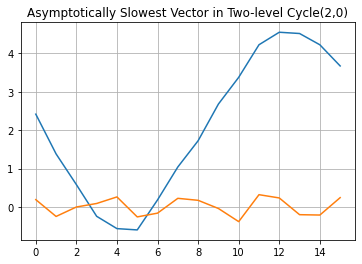

In [137]:
# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - local_multilevel[1].p.dot(local_multilevel[1].r.dot(y))
plt.plot(y);
plt.plot(e);
plt.grid(True);

In [138]:
two_level_conv = np.array([
    two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values])

conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level"))
display(conv)

,Mock,Two-level
1,0.46,0.49
2,0.23,0.38
3,0.12,0.48
4,0.13,0.45
5,0.10,0.42
6,0.08,0.41
7,0.08,0.40
8,0.07,0.38


This intepolation is good up to $\nu = 2$, conv $\approx 0.35$.

<!-- ### Build Coarse Level: Two-level Bootstrap Cycle -->

In [139]:
# max_levels = 2
# num_bootstrap_steps = 1

# # Bootstrap with an increasingly deeper hierarchy (add one level at a time).
# num_levels = 2
# _LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
# _LOGGER.info("-" * 80)
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
#     x, multilevel = hm.setup.auto_setup.bootstap(
#         x, multilevel, num_levels, 2.0,
#         num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
#         neighborhood=neighborhood, repetitive=repetitive, target_error=0.1)
#     x_log.append(x)
#     r_log.append(multilevel[1].r)
#     _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
#     _LOGGER.info("-" * 80)

### Two-level Hierarchy

In [142]:
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)
l = 1
r_csr = r.tile(n // aggregate_size)
p_csr = r_csr.transpose()
level1 = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
_LOGGER.info("Level {} size {}".format(l, level1.size))
multilevel.add(level1)

96 (48, 96)
INFO     Level 1 size 48


#### Level 0

In [144]:
pd.DataFrame(multilevel[0].a.tocsr()[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25


#### Level 1

In [145]:
pd.DataFrame(multilevel[1].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.24,-0.00,0.24,0.36,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.00,-1.44,-0.35,-0.54,0.00,0.00,0.00,0.00,0.00,0.00
2,0.24,-0.35,-0.24,-0.00,0.24,0.36,0.00,0.00,0.00,0.00
3,0.36,-0.54,-0.00,-1.44,-0.35,-0.54,0.00,0.00,0.00,0.00
4,0.00,0.00,0.24,-0.35,-0.24,-0.00,0.24,0.36,0.00,0.00
5,0.00,0.00,0.36,-0.54,-0.00,-1.44,-0.35,-0.54,0.00,0.00
6,0.00,0.00,0.00,0.00,0.24,-0.35,-0.24,-0.00,0.24,0.36
7,0.00,0.00,0.00,0.00,0.36,-0.54,-0.00,-1.44,-0.35,-0.54
8,0.00,0.00,0.00,0.00,0.00,0.00,0.24,-0.35,-0.24,-0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.36,-0.54,-0.00,-1.44


In [146]:
pd.DataFrame(multilevel[1].p[:10, :10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.46,-0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.53,-0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.55,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.46,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.46,-0.66,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,-0.53,-0.27,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,-0.55,0.27,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.46,0.65,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,-0.46,-0.66,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,-0.53,-0.27,0.00,0.00,0.00,0.00


In [147]:
pd.DataFrame(multilevel[1].r[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.46,-0.53,-0.55,-0.46,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.27,0.27,0.65,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.46,-0.53,-0.55,-0.46,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.27,0.27,0.65,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.46,-0.53
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.66,-0.27
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Test Multilevel Cycle Convergence

<!-- ### Solving $A x = b$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. $b$ is a random periodic vector. We start from random $x$. Solving exactly on the coarsest level works fine despite the indefiniteness since the matrix is not (even nearly) singular. -->

In [148]:
# level = multilevel.finest_level
# # Test two-level cycle convergence for A*x=0 and  A*x=b with random b.
# for title, b in (("0", np.zeros((a0.shape[0], ))), ("b", np.random.random((a0.shape[0], )))):
#     logger.info("Ax={}".format(title))
#     two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 2, 1, nu_coarsest=-1, debug=False, rhs=b).run(y)
#     residual = lambda x: b - multilevel[0].operator(x)
#     x, conv_factor = hm.solve.run.run_iterative_method(residual, two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

In [149]:
# # Asymptotic vector.
# e = x - multilevel[1].p.dot(multilevel[1].r.dot(x))
# plt.plot(x);
# plt.plot(e);

In [150]:
# # L2 interpolation error
# logger.info("|x-P*R*x|     {:.2e}".format(hm.linalg.scaled_norm(e)))
# logger.info("|x|           {:.2e}".format(hm.linalg.scaled_norm(x)))

# # Residual norm interpolation error
# logger.info("|A*(x-P*R*x)| {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(e))))
# logger.info("|Ax|          {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(x))))

In [151]:
# nu_values = np.arange(1, 7, dtype=int)
# r = multilevel[1].r
# two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
# residual = lambda x: b - multilevel[0].operator(x)
# b = np.random.random((a0.shape[0], ))
# mock_conv_factor = np.array([
#     hm.setup.auto_setup.mock_cycle_conv_factor(multilevel.finest_level, r, nu) 
#     for nu in nu_values])
# two_level_cycle = np.array([
#     hm.solve.run.run_iterative_method(
#         residual, 
#         lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, rhs=b).run(x), 
#         np.random.random((multilevel.finest_level.size, )), 20)[1]
#     for nu in nu_values])

# for nu, mock, two_level in zip(nu_values, mock_conv_factor, two_level_cycle):
#     print("V({}, {}) conv factor {:.3f} mock cycle {:.3f}".format(nu, 0, two_level, mock))

<!-- For some reason, 1 relaxation per cycle is more efficient than $2-4$ per cycle! Note that we are solving $Ax=b$, not $Ax=0$. -->

## Spectra of Different Levels

In [152]:
# # Calculate eigenpairs at all levels.
# vl = []
# laml = []
# for l, level in enumerate(multilevel):
#     a = level.a
#     lam, v = eig(a.todense())
#     lam = np.real(lam)
#     ind = np.argsort(np.abs(lam))
#     lam = lam[ind]
#     v = v[:, ind]
#     vl.append(v)
#     laml.append(lam)
#     print(l, "lam", lam[:13])
    
# # Interpolate eigenvectors at all levels to the finest level.
# num_levels = len(multilevel)
# vl_finest = []
# for l in range(num_levels):
#     v = vl[l]
#     for k in range(l, 0, -1):
#         v = multilevel[k].p.dot(v)
#     vl_finest.append(v)

In [153]:
# num_ev = 8
# num_levels = len(multilevel)
# fig, axs = plt.subplots(num_ev, num_levels, figsize=(16, 16))

# for col, ax in enumerate(axs[0]):
#     ax.set_title("Level {}".format(col))

# for i in range(num_ev):
#     for l in range(num_levels):
#         ax = axs[i, l]
#         ax.plot(np.real(vl[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
#         ax.legend(loc="upper right")
#         ax.grid(True);